<h1><center>ПРЕДСКАЗАНИЕ УРОЖАЯ ОЗИМЫХ ТРИТИКАЛЕ С ПОМОЩЬЮ НЕЙРОННЫХ СЕТЕЙ</center></h1>

---

## Введение

---

<div class="text-justify">
В данной работе попробуем применить несколько способов предсказания урожайности озимых тритикале и выберем наиболее лучший. Помимо нейросети посмотрим бейзлайн (базовое, самое простое решение) и обычную линейную модель.
</div>

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from typing import Union, Sequence
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

In [9]:
# Путь к данным
PATH = '' #'/content/drive/MyDrive/urozhaj/'

In [10]:
# Загрузка данных
data = pd.read_csv(PATH + 'urozhaj.csv', decimal=',')

In [11]:
data

,T_posev-vskhod,H_posev-vskhod,T_vskhod-kuschenie,H_vskhod-kuschenie,T_kuschenie-trubka,H_kuschenie-trubka,T_trubka-koloshenie,H_trubka-koloshenie,T_koloshenie-sozrevanie,H_koloshenie-sozrevanie,...,Gumus,P,K,vlazhnost,T_pochvy_posev,y_konsul,y_nina,y_topaz,y_mikhas,y_nemch56
0,11.926667,22.0,9.753333,14.500000,8.417778,18.166667,16.483333,14.750000,18.861905,34.600000,...,1.80,120,135,21,5,33.2,30.3,32.4,27.7,29.7
1,12.357143,10.0,10.866667,8.333333,10.306667,16.333333,13.676667,27.750000,17.713333,20.600000,...,1.86,125,125,22,5,63.4,59.3,60.7,58.8,59.7
2,12.257143,22.0,10.926667,9.666667,9.838636,7.166667,17.725806,37.500000,17.751020,13.800000,...,2.00,156,136,18,6,65.8,60.7,62.3,60.4,57.2
3,12.442857,3.5,5.933333,8.333333,9.046667,10.000000,18.041935,37.500000,16.706250,13.800000,...,1.98,110,128,20,5,53.8,50.5,52.7,48.9,48.1
4,12.353333,10.0,6.086667,12.500000,9.048780,11.833333,14.481250,12.525000,16.953333,19.000000,...,2.10,139,133,30,7,48.8,45.0,47.6,46.1,44.3
5,12.385714,26.0,13.546667,10.333333,7.724444,11.340000,13.877419,39.666667,18.843636,30.666667,...,2.00,155,141,26,8,37.3,36.4,38.4,35.1,33.3
6,12.185714,13.5,9.593333,45.500000,5.011364,22.000000,13.351613,25.000000,16.471429,31.333333,...,2.21,145,135,20,7,56.1,54.7,54.6,52.1,52.7
7,13.557143,23.0,9.820000,24.666667,10.668889,21.183333,14.322581,17.750000,18.055172,49.550000,...,1.96,158,144,18,7,46.9,44.1,45.7,39.2,40.1
8,15.028571,7.5,9.000000,30.666667,10.062222,14.266667,17.535484,12.750000,16.091667,30.571429,...,2.01,150,134,19,8,65.1,60.8,64.4,59.7,57.2
9,8.257143,14.0,7.320000,26.500000,8.820930,22.600000,15.025806,37.250000,17.410714,31.000000,...,1.85,152,138,23,5,54.8,52.3,56.3,49.4,49.8


In [12]:
# Будем сохранять ошибки в словарь для сравнения
total_info = {}

In [13]:
# Делим датасет на признаки и таргеты
feature_names = data.iloc[:, :16].columns
target_names = data.iloc[:, 16:].columns
X, Y = data[feature_names], data[target_names]

### Baseline

<div class="text-justify">
Посмотрим бейзлайн по всем культурам. В качестве тестовой выборки будем смотреть на значение урожая в последний год. Возьмем его как среднее значение урожая за все предыдущие года.
</div>

In [14]:
baseline_preds = Y.loc[:8].mean()
print('BASELINE:', baseline_preds, sep='\n')

BASELINE:
y_konsul     52.266667
y_nina       49.088889
y_topaz      50.977778
y_mikhas     47.555556
y_nemch56    46.922222
dtype: float64


In [15]:
# Сохраняем нужную информацию в словарь
total_info['Y_true'] = Y.iloc[-1, :].values
total_info['Baseline'] = baseline_preds.values

### Linear regression

Посмотрим, улучшится ли предсказание, если использовать простейую модель - линейную регрессию. Здесь `y_pred` - предсказанное значение урожайности, `y_train`/`y_test` (`y_true`) - истинное значение, полученное на практике.

In [16]:
linreg_hist = {'models': [], 'y_preds': [], 'mse_errors': []}
# Пробегаем цикл по каждой культуре
for col in Y.columns:
    # train-test split
    X_train, y_train, X_val, y_val = X.loc[:8], Y[col].loc[:8], X.loc[9:], Y[col].loc[9:]
    # обезразмеривание
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    # Обучение модели
    linreg = LinearRegression().fit(X_train_scaled, y_train)
    # Предсказание на последнем годе
    y_pred = linreg.predict(X_val_scaled)[0]
    # Считаем относительную ошибку
    error = abs(y_val - y_pred) / y_val 
    # Сохраняем модели, предсказания и ошибки
    linreg_hist['models'].append(linreg)
    linreg_hist['y_preds'].append(y_pred)
    linreg_hist['mse_errors'].append(error.values[0])

In [17]:
# Предсказания и ошибки на последний год для 5 культур
linreg_hist['y_preds'], linreg_hist['mse_errors']

([46.88815988506211,
  43.864929322009544,
  42.97109576123745,
  40.528763075281645,
  42.44828433491549],
 [0.14437664443317316,
  0.16128242214130886,
  0.23674785504018736,
  0.17957969483235534,
  0.14762481255189772])

In [18]:
# Сохраняем предсказания в словарь
total_info['Linreg'] = linreg_hist['y_preds']

### Нейросетевая модель

<div class="text-justify">Для решения задачи предсказания урожайности будем использовать модель, базирующуюся на простейшей глубокой сети с одним скрытым слоем. Увеличение количества скрытых слоев приводит к значительному росту количества обучаемых параметров, что в случае малого количества данных приведет к переобучению модели: модель для таких данных оказывается слишком сложной.
</div>
    
<div class="text-justify">
Скрытый слой представляет собой нейроны, являющиеся линейной комбинацией исходных признаков с функцией активации $\sigma$ - сигмода:
</div>
<font size=4>
\begin{align}
\sigma = \frac{1}{1 + e^{-x}}
\end{align}
</font>

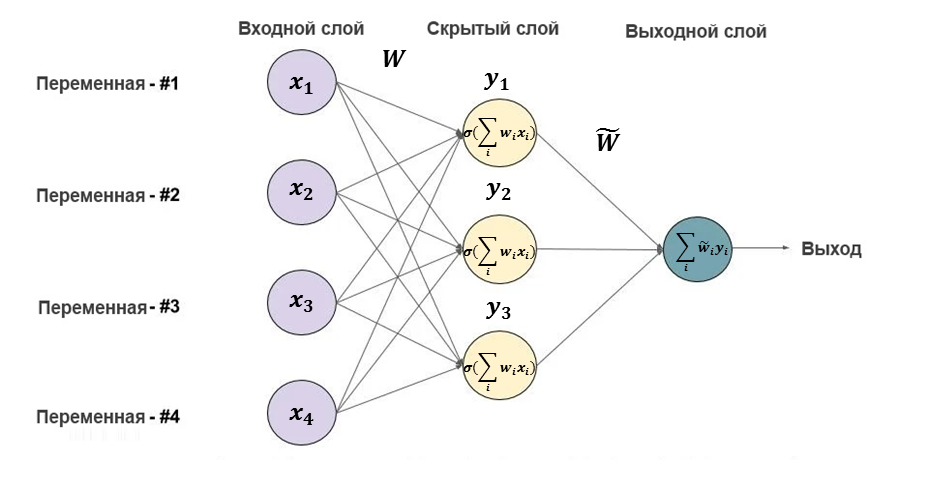

<div class="text-justify">
В качестве метрики (здесь совпадает с функцией потерь - loss function), как и для многих регрессионных задач, выберем MSE (mean squared error, среднеквадратичная ошибка):
</div>

<font size=4>
\begin{align}
MSE = \frac{1}{N}\sum\limits_{i=1}^N(y_{pred, i} - y_{true, i})^2
\end{align}
</font>

In [76]:
# Нейросеть
class NNet(nn.Module):
    def __init__(self, 
                 n_inputs: int, 
                 n_layers: int, 
                 n_neurons: Union[Sequence[int], int], 
                 bias: bool=True):
        super().__init__()
        if not isinstance(n_inputs, int) or not isinstance(n_layers, int):
            raise TypeError("Введенные значения должны быть целыми числами")

        if len(n_neurons) != n_layers:
            raise ValueError("Количество нейронов должно быть равно числу слоев")
        n_neurons = [n_neurons] if isinstance(n_neurons, int) else n_neurons
        self.channels = [(n_inputs, n_neurons[0])] + \
                        [(n_neurons[i], n_neurons[i+1]) for i in range(len(n_neurons)-1)]
        self.net = nn.ModuleList([nn.Linear(*cnls, bias=bias) for cnls in self.channels])

    def forward(self, x):
        x = torch.from_numpy(x).float()
        for layer in self.net[:-1]:
            x = torch.sigmoid(layer(x))
        return self.net[-1](x)


# Модель
class TriticaleModel:
    def __init__(self,    
                 n_inputs: int, 
                 n_layers: int, 
                 n_neurons: Union[Sequence[int], int], 
                 bias: bool=True,
                 lr: float=0.1,
                 random_seed: int=None):
        self.random_seed = torch.manual_seed(random_seed) if random_seed else random_seed
        self.model = NNet(n_inputs, n_layers, n_neurons, bias)
        self.loss_fn = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def load_model(self, model_path: str=None) -> None:
        """
        Метод загрузка параметров модели
        """
        self.model.load_state_dict(torch.load(model_path))

    def train(self, X_train, y_train, X_val, y_val, n_epochs: int, save_path: str=None):
        curr_loss = float('inf')
        train_loss = []
        valid_loss = []
        y_train = torch.from_numpy(y_train.values).float().unsqueeze(1)
        y_val = torch.from_numpy(y_val.values).float().unsqueeze(1)

        for _ in range(n_epochs):
            # обучение
            self.model.train()
            self.optimizer.zero_grad()
            output = self.model(X_train)
            loss = self.loss_fn(output, y_train)
            loss.backward()
            self.optimizer.step()
            train_loss.append(loss.item())
            # валидация
            self.model.eval()
            with torch.no_grad():
                output = self.model(X_val)
                loss = self.loss_fn(output, y_val)
                valid_loss.append(loss.item())
                # Сохраняем параметры лучшей модели  
                if loss.item() < curr_loss and save_path:
                    torch.save(self.model.state_dict(), save_path)
                    curr_loss = loss.item()
        return train_loss, valid_loss

    def predict(self, X, y = None):
        """
        Метод предсказания и получения ошибки прогноза
        """
        self.model.eval()

        if y is not None:
            y = torch.tensor(np.array(y)).unsqueeze(0)
        with torch.no_grad():
            output = self.model(X)
            loss = self.loss_fn(output, y).item() if y else None
        return output.item(), loss

    def get_all_predictions(self, X, y, percent=True, print_tab=True):
        """
        Метод получения предсказаний и ошибок по всем данным
        Опция вывода таблицы полученных значений
        """
        from tabulate import tabulate

        predictions = {}
        for i in range(X.shape[0]):
            y_pred, loss = self.predict(X[i, :], y[i])
            predictions.setdefault('Year', []).append(2010 + i)
            predictions.setdefault('Predictions', []).append(y_pred)
            predictions.setdefault('Absolute Error', []).append(loss ** 0.5)
            predictions.setdefault('Relative Error', []).append(round(loss ** 0.5 / y[i], 3))
        if percent:
            to_percent = lambda x: str(round(100 * x, 1)) + ' %'
            predictions['Relative Error'] = list(map(to_percent, predictions['Relative Error']))
        if print_tab:
            print(tabulate(list(zip(*predictions.values())), headers=predictions.keys()))
        return predictions

    @staticmethod
    def relative_error(y_pred, y_true):
        """
        Метод вычисления относительной ошибки прогноза
        """
        return abs(y_pred - y_true) / y_true
    
    
# Функция предобработки данных
def preprocessing(X, Y, row_num):
    # Делим на данные на трейновую часть и валидационную
    X_train, Y_train, X_val, Y_val = X.loc[:row_num], Y.loc[:row_num], X.loc[row_num + 1:], Y.loc[row_num + 1:]

    # обезразмеривание по формулам выше
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train) # получаем стандартное отклоение и среднее по обучающей выборке
    X_val_scaled = scaler.transform(X_val)         # на валидации применяем (без fit) полученное выше, т.к. 
                                                   # не можем знать параметры из новых данных
    return X_train_scaled, Y_train, X_val_scaled, Y_val


# Функции для отрисовки графиков
# Обучение
def learning_plot(train_loss, valid_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(train_loss)
    plt.plot(valid_loss)
    plt.title('Ошибка нейросети во время обучения и валидации', fontsize=20)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('MSE', fontsize=15)
    plt.legend(['train', 'valid'], fontsize='large')
    plt.show()


# Гистограмма результатов
def barplot(x, y_pred, target, target_name):
    plt.figure(figsize=(12, 8))
    index = np.arange(10)
    bw = 0.3
    plt.axis([-0.3, 10, 0, 80])
    plt.title(f'Эксперимент и предсказание для культуры {target_name}', fontsize=20)
    plt.bar(index, target, bw, color='b')
    plt.bar(index+bw, y_pred, bw, color='g')
    plt.ylabel('Урожайность, ц/га', fontsize=20)
    plt.yticks(fontsize=15)
    plt.xticks(index+bw/2, x, fontsize=15)
    plt.legend(['Эксперимент', 'Предсказание'], fontsize='large')
    plt.show()


def write_list(a_list, file_name='listfile'):
    """
    Записать список в бинарный файл.
    Cохранить список в двоичном файле, поэтому режим «wb».
    """
    with open(PATH + file_name, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')


def read_list(file_name='listfile'):
    """
    Считать список в оперативную память.
    Для чтения также используется бинарный режим.
    """
    with open(PATH + file_name, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list
    

# Функции для генерации новых объектов (строк) данных
def get_extreme_value(data, feat_letters, start_value, operation):
    """
    Функция для получения экстремальных (max/min) значений определенных признаков по датасету
    
    Параметры:
        data: датасет
        feat_letters (str): общая часть имени признаков (фильтрация)
        start_value (int | float): min/max значение признака для старта поиска max/min соответственно
        operation: (str): 'min' или 'max'
    """
    for col_name in data.columns:
        cur = data.describe()[col_name].loc[operation]
        if feat_letters in col_name and start_value < cur and operation == 'max':
            start_value = cur
        if feat_letters in col_name and start_value > cur and operation == 'min':
            start_value = cur
    return start_value


def add_value_to_new_row(data, feat_letters, value):
    """
    Функция для получения экстремальных (max/min) значений определенных признаков по датасету
    
    Параметры:
        data: датасет
        feat_letters (str): общая часть имени признаков (фильтрация)
        value (int | float): значение, которое необходимо вставить в новую строку датафрейма
    """
    data_new = data.copy()
    # Новая строка добавляется случайным выбором из старых с последующей заменой некоторых значений признаков
    data_new.loc[len(data_new.index)] = data.sample().values.flatten() #len(data_new.columns) * (0,)
    for col_name in data_new.columns:
        if feat_letters in col_name:
            data_new.loc[len(data_new) - 1, col_name] = value
    return data_new    

## Предобработка данных

---

Отмасштабируем признаки таким образом, чтобы среднее значение наблюдаемых значений было равно 0, а стандартное отклонение – 1:

<font size=4>
\begin{align}
z = \frac{x - \mu}{\sigma},
\end{align}
</font>

где $\mu = \frac{1}{N}\sum\limits_{i=1}^Nx_{i}$ - среднее, $\sigma = \sqrt{\frac{1}{N}\sum\limits_{i=1}^N(x_{i} - \mu)^2}$ - стандартное отклонение.

In [20]:
# Train-test split (деление данных на обучение и валидацию/тест)
X_train_scaled, Y_train, X_val_scaled, Y_val = preprocessing(X, Y, 8)

In [21]:
# Для итогового прогноза по всем данным, накоторых учились и объекте, который нейросеть не видела
X_scaled = np.vstack((X_train_scaled, X_val_scaled))

## Подбор оптимального числа нейронов в скрытом слое нейросети

---

<div class="text-justify">
Обучим модели для каждой культуры с разным числом нейронов в скрытом слое. Будем обращать обращать внимание на среднюю относительную ошибку, которая вычисляется по формуле:
</div>
    
<font size=4>
\begin{align}
\varepsilon_{rel} = \Bigg|\frac{y_{pred} - y_{true}}{y_{true}}\Bigg|
\end{align}
</font>

In [22]:
num_neurons = (10, 15, 20, 25, 30, 35, 40, 50)
varieties = {'konsul': '"Консул"', 'nina': '"Нина"', 'topaz': '"Топаз"', 
             'mikhas': '"Михась"', 'nemch56': '"Немчиновский 56"'}
errors_dct = {}

for label in varieties: # Пробегаем по всем культурам
    for n_neurons in num_neurons: # Пробегаем по всем количествам нейронов
        # Создаем объект модели
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                        n_layers=2, 
                                        n_neurons=(n_neurons, 1), 
                                        random_seed=100)

        # Обучаем модель
        train_loss, valid_loss = model.train(X_train_scaled, 
                                             Y_train[f'y_{label}'], 
                                             X_val_scaled, 
                                             Y_val[f'y_{label}'],
                                             300)

        # Предсказываем урожайность на всех данных
        predictions = model.get_all_predictions(X_scaled, Y[f'y_{label}'], False, False)
        # Сохраняем ошибки, по которым далее построим графики
        errors_dct.setdefault(label, {})[n_neurons] = predictions['Relative Error']

Построим полученные зависимости

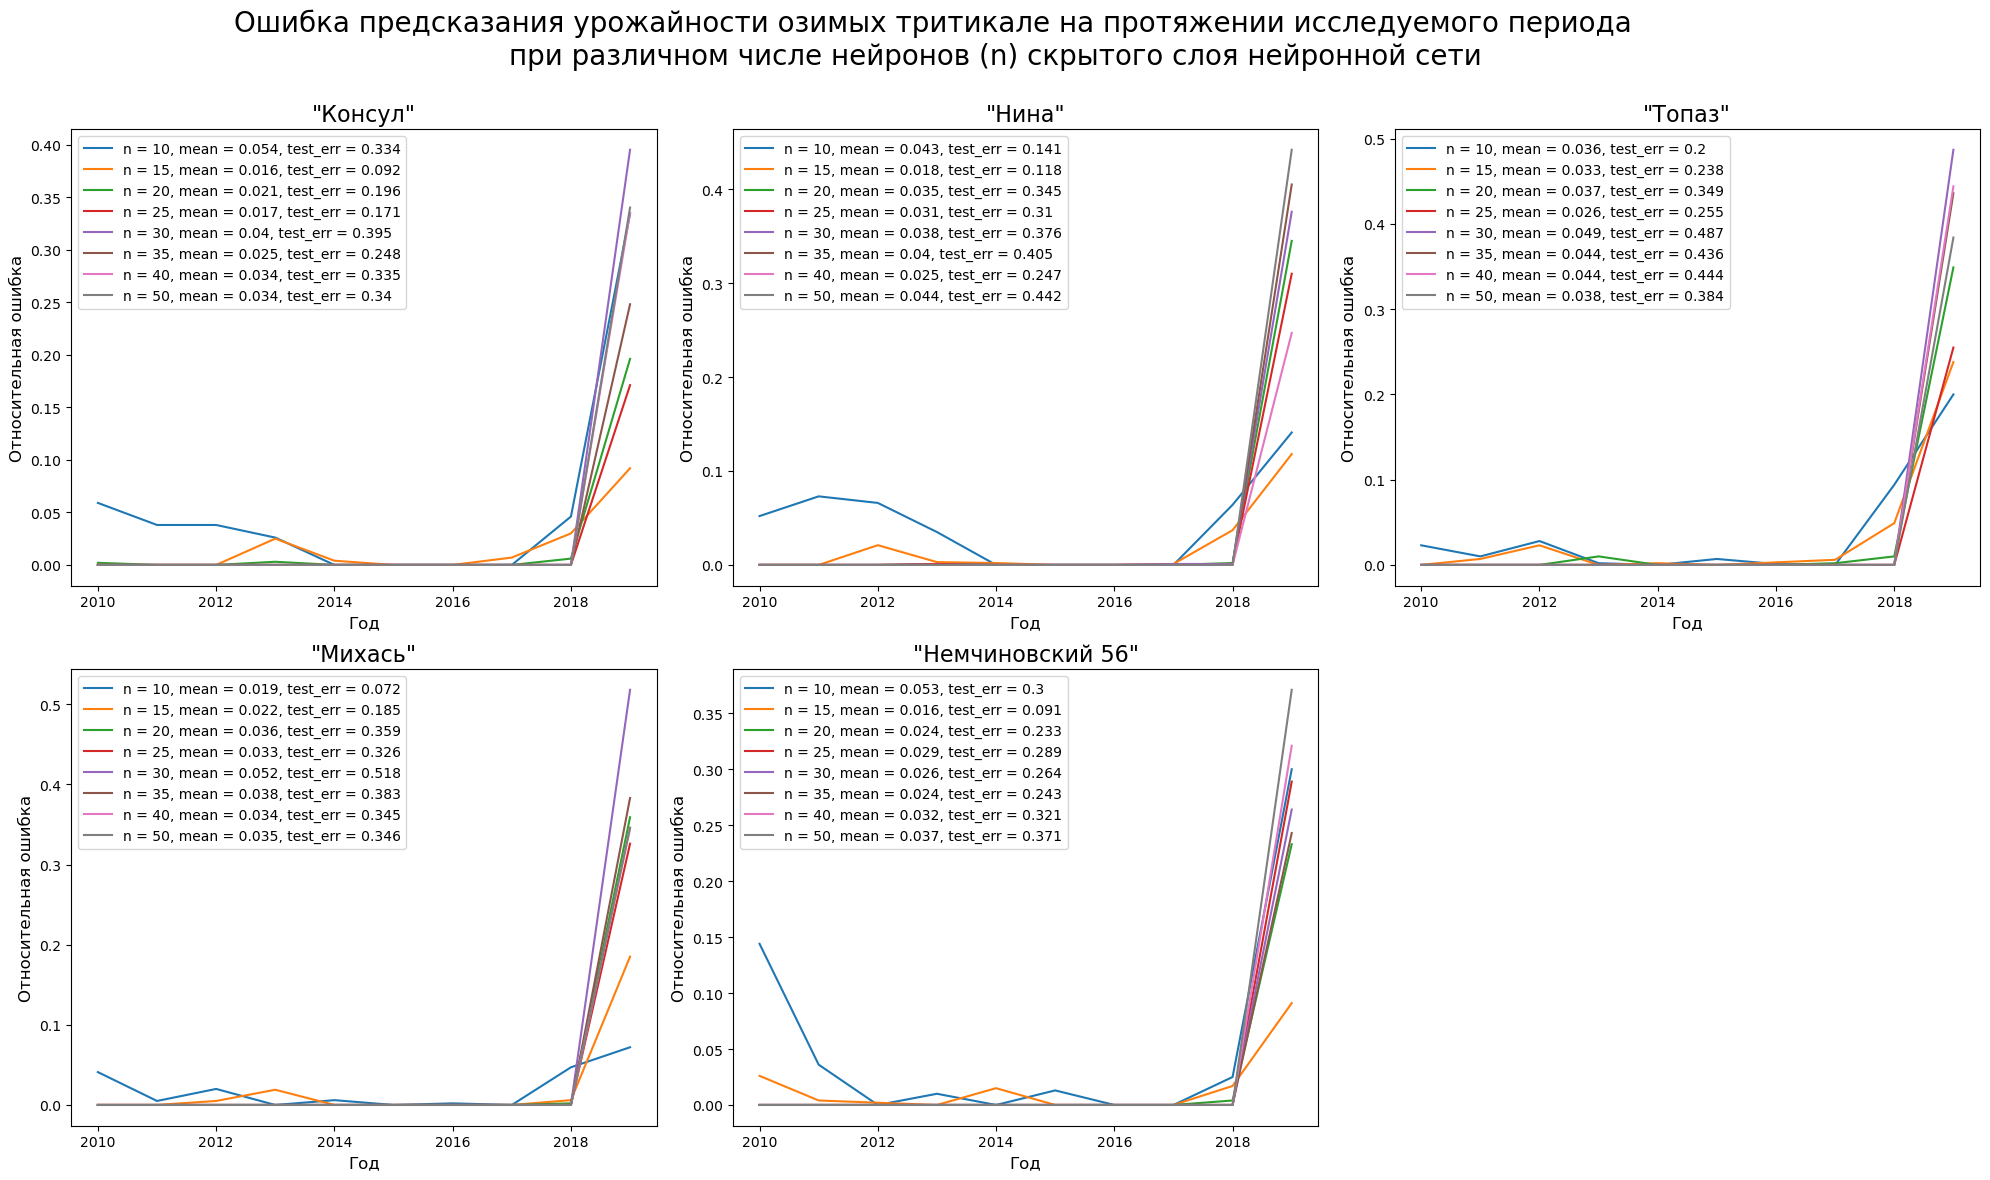

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.delaxes(axes[1][2])
fig.suptitle("Ошибка предсказания урожайности озимых тритикале на протяжении исследуемого периода\
              \nпри различном числе нейронов (n) скрытого слоя нейронной сети", fontsize=20)
test_err = {} # Сохраним ошибку на тестовом 2019-м годе для следующего графика

for ax, label in zip(axes.flatten(), varieties):
    for i, n_neurons in enumerate(num_neurons):
        values = list(errors_dct[label].values())[i]
        test_err.setdefault(label, {})[n_neurons] = values[-1]
        mean = np.mean(values).round(3)        
        legend = f'n = {n_neurons}, mean = {mean}, test_err = {values[-1]}'
        ax.plot(predictions['Year'], list(errors_dct[label].values())[i], label=legend)
        ax.set_title(varieties[label], fontsize=16)
        ax.set_ylabel('Относительная ошибка', fontsize=12)
        ax.set_xlabel('Год', fontsize=12)
        ax.grid()
        ax.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.88)

In [24]:
# Посмотрим при скольких нейронах в скрытом слое ошибка минимальна
for label in varieties:
    list_min = []
    for n_neurons in num_neurons:
        list_min.append(errors_dct[label][n_neurons][-1])
    print(label, num_neurons[np.argmin(list_min)], min(list_min), sep=': ')

konsul: 15: 0.092
nina: 15: 0.118
topaz: 10: 0.2
mikhas: 10: 0.072
nemch56: 15: 0.091


На тестовом (валидационном) 2019 годе (последняя точка зависимостей) можно видеть заметное увеличение относительной ошибки, что вполне естественно, так как модель не обучалась на этих данных. В легенде ошибка на тесте отражена численно (**_test_err_**).

Кроме того, была оценена средняя относительная ошибка на всех данных, обозначенная в легенде как **_mean_**, которая может характеризовать стабильность модели к данным. Минимальная средняя относительная ошибка для культур "Консул", "Нина" и "Топаз" наблюдалась при 10 нейронах, для "Михась" - 35, а для "Немчиновский 56" - 25.

Теперь для наглядности развернем последние точки предыдущих графиков: построим тестовую ошибку по последнему году для всех культур с помощью полученного выше *test_err* и определим оптимальное число нейронов, исходя уже из предсказания только на тестовых данных.

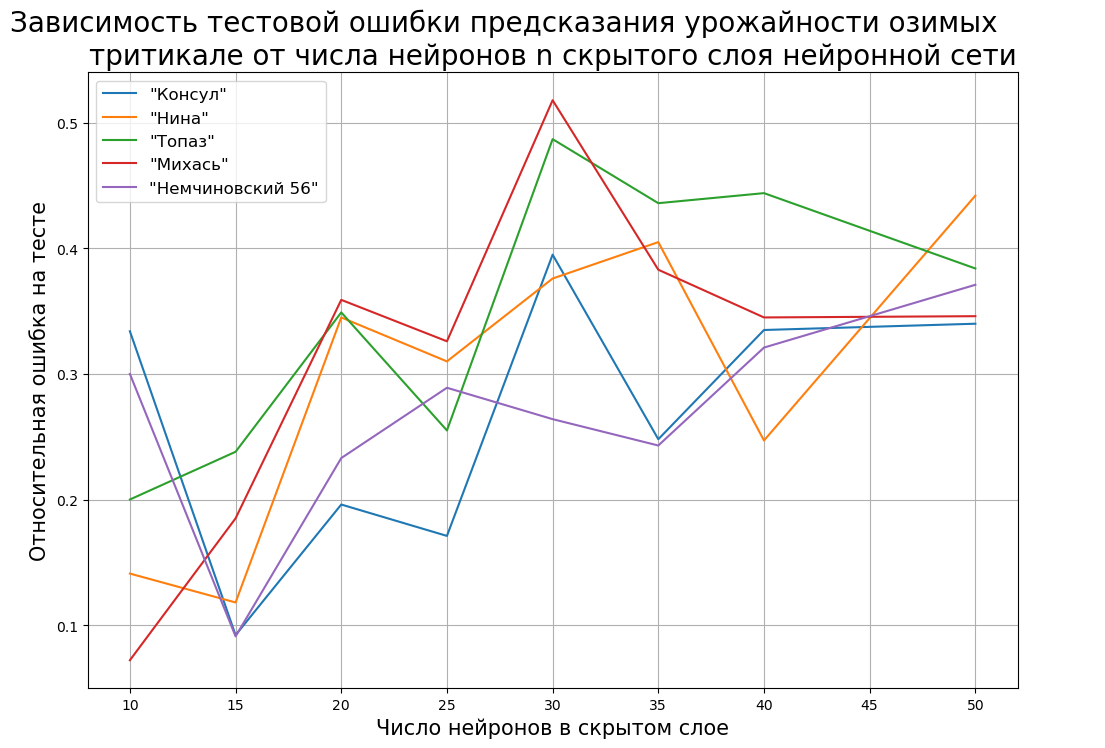

In [25]:
plt.figure(figsize=(12, 8))
plt.title("Зависимость тестовой ошибки предсказания урожайности озимых\
           \nтритикале от числа нейронов n скрытого слоя нейронной сети", fontsize=20)
for label in varieties:
    legend = varieties[label]
    plt.plot(list(test_err[label].keys()), list(test_err[label].values()), label=legend)
    plt.xlabel('Число нейронов в скрытом слое', fontsize=15)
    plt.ylabel('Относительная ошибка на тесте', fontsize=15)
    plt.grid()
    plt.legend(fontsize='large')

Видно, что для большинства культур минимальная ошибка достигается также при 10 нейронах в скрытом слое. 

Теперь заново обучим под каждую культуру модели со своим значением числа нейронов и посмотрим более детально на обучение и предсказания.

## Обучение моделей и результаты

---
### Культура "Консул"

In [26]:
# Сохраним результаты предсказаний и можели
all_preds = {}
nn_models = {}

In [27]:
model_konsul = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                              n_layers=2, 
                              n_neurons=(10, 1), 
                              random_seed=1)

train_loss, valid_loss = model_konsul.train(X_train_scaled, 
                                            Y_train.y_konsul, 
                                            X_val_scaled, 
                                            Y_val.y_konsul, 
                                            300,
                                            PATH + 'konsul.pt')

# Загружаем веса лучшей модели, сохраненной после обучения
model_konsul.load_model(PATH + 'konsul.pt')

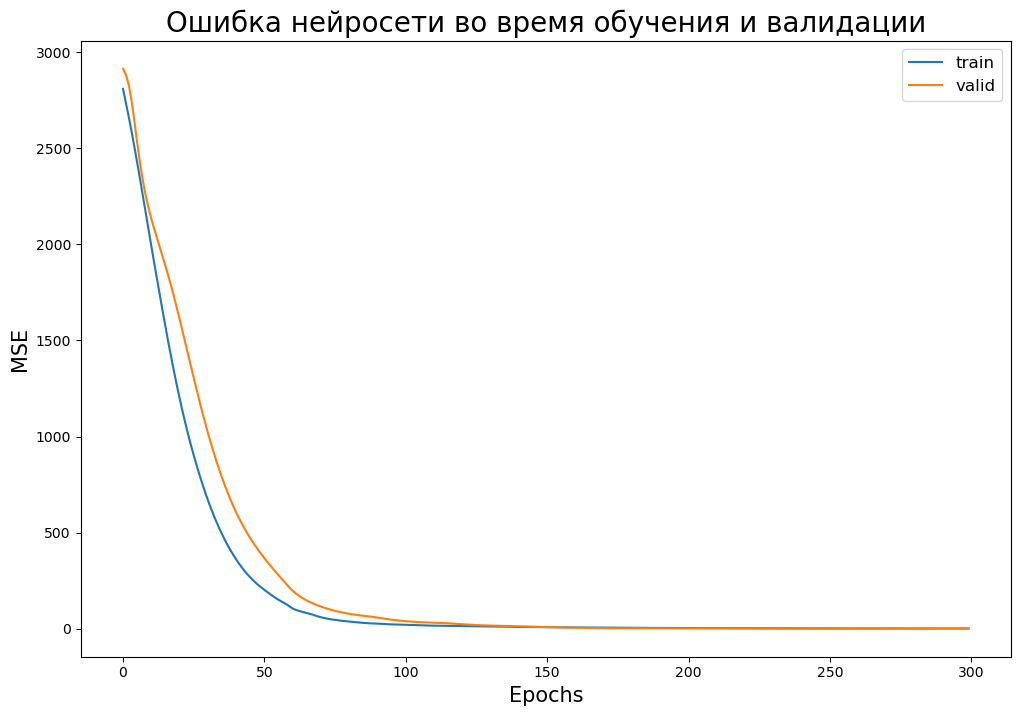

In [28]:
learning_plot(train_loss, valid_loss)

In [29]:
Y.y_konsul

0    33.2
1    63.4
2    65.8
3    53.8
4    48.8
5    37.3
6    56.1
7    46.9
8    65.1
9    54.8
Name: y_konsul, dtype: float64

In [30]:
predictions = model_konsul.get_all_predictions(X_scaled, Y.y_konsul)

  Year    Predictions    Absolute Error  Relative Error
------  -------------  ----------------  ----------------
  2010        33.3003        0.100297    0.3 %
  2011        63.3369        0.0630936   0.1 %
  2012        61.6341        4.16585     6.3 %
  2013        54.508         0.708026    1.3 %
  2014        48.7893        0.0107468   0.0 %
  2015        37.3232        0.0231812   0.1 %
  2016        56.083         0.0170074   0.0 %
  2017        46.8516        0.0483879   0.1 %
  2018        65.5793        0.479254    0.7 %
  2019        54.7948        0.00523453  0.0 %


In [31]:
# Сохраним все предсказания и ошибку предсказания для Консула на последний год
nn_error = model_konsul.get_all_predictions(X_scaled, Y.y_konsul, False, False)['Relative Error'][-1]
total_info.setdefault('NN_rel_error', []).append(nn_error)
all_preds['konsul'] = predictions['Predictions']
nn_models['konsul'] = model_konsul

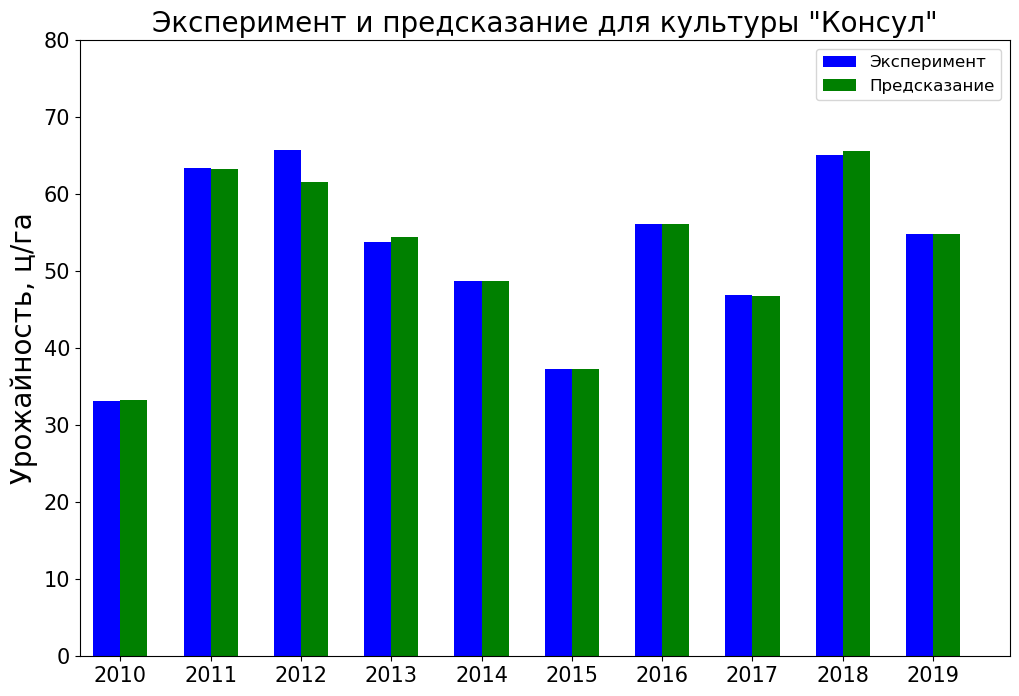

In [32]:
barplot(predictions['Year'], predictions['Predictions'], Y.y_konsul, '"Консул"')

### Культура "Нина"

In [33]:
model_nina = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                            n_layers=2, 
                            n_neurons=(10, 1),
                            random_seed=1)

train_loss, valid_loss = model_nina.train(X_train_scaled, 
                                          Y_train.y_nina, 
                                          X_val_scaled, 
                                          Y_val.y_nina, 
                                          300,
                                          PATH + 'nina.pt')

model_nina.load_model(PATH + 'nina.pt')

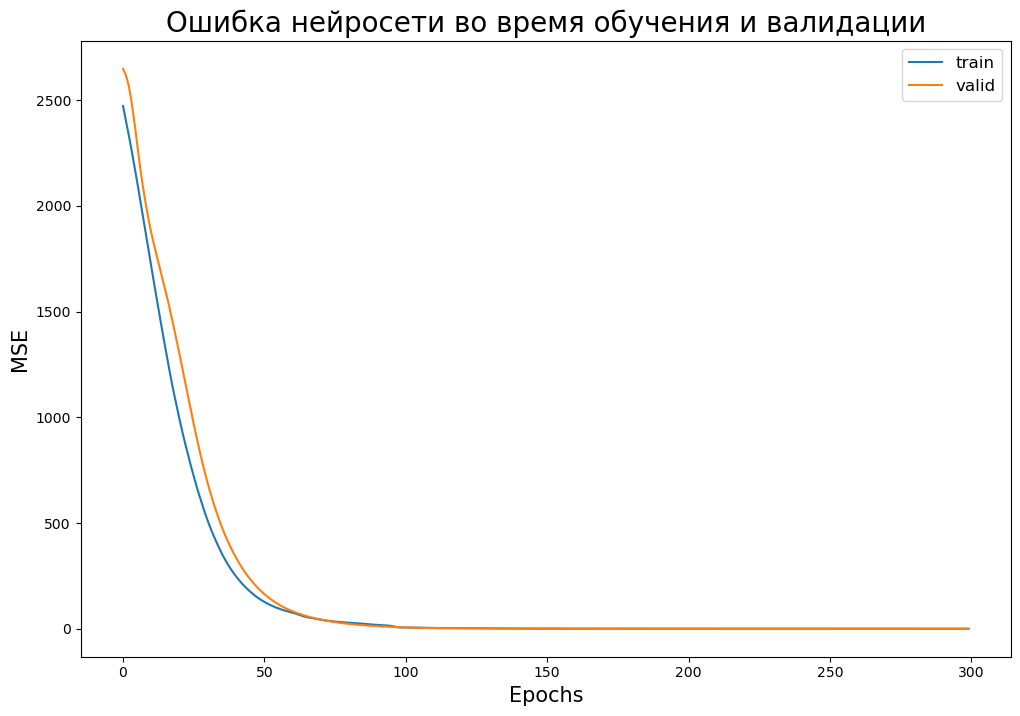

In [34]:
learning_plot(train_loss, valid_loss)

In [35]:
predictions = model_nina.get_all_predictions(X_scaled, Y.y_nina)

  Year    Predictions    Absolute Error  Relative Error
------  -------------  ----------------  ----------------
  2010        29.5144       0.785594     2.6 %
  2011        60.0049       0.704871     1.2 %
  2012        60.5789       0.121062     0.2 %
  2013        50.5068       0.0067749    0.0 %
  2014        44.9978       0.00222015   0.0 %
  2015        36.4001       0.000146484  0.0 %
  2016        54.7086       0.00856476   0.0 %
  2017        44.1          1.52588e-06  0.0 %
  2018        60.6008       0.199204     0.3 %
  2019        52.1107       0.189294     0.4 %


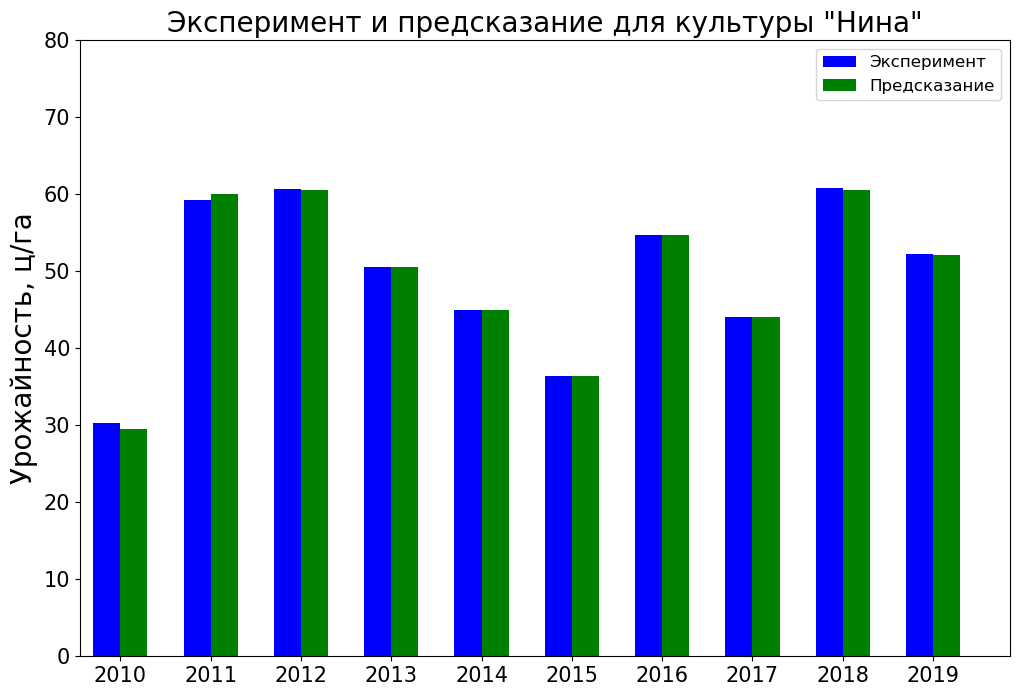

In [36]:
barplot(predictions['Year'], predictions['Predictions'], Y.y_nina, '"Нина"')

In [37]:
nn_error = model_nina.get_all_predictions(X_scaled, Y.y_nina, False, False)['Relative Error'][-1]
total_info.setdefault('NN_rel_error', []).append(nn_error)
all_preds['nina'] = predictions['Predictions']
nn_models['nina'] = model_nina

### Культура "Топаз"

In [38]:
model_topaz = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                             n_layers=2, 
                             n_neurons=(10, 1), 
                             random_seed=1)

train_loss, valid_loss = model_topaz.train(X_train_scaled, 
                                           Y_train.y_topaz, 
                                           X_val_scaled, 
                                           Y_val.y_topaz, 
                                           300,
                                           PATH + 'topaz.pt')

model_topaz.load_model(PATH + 'topaz.pt')

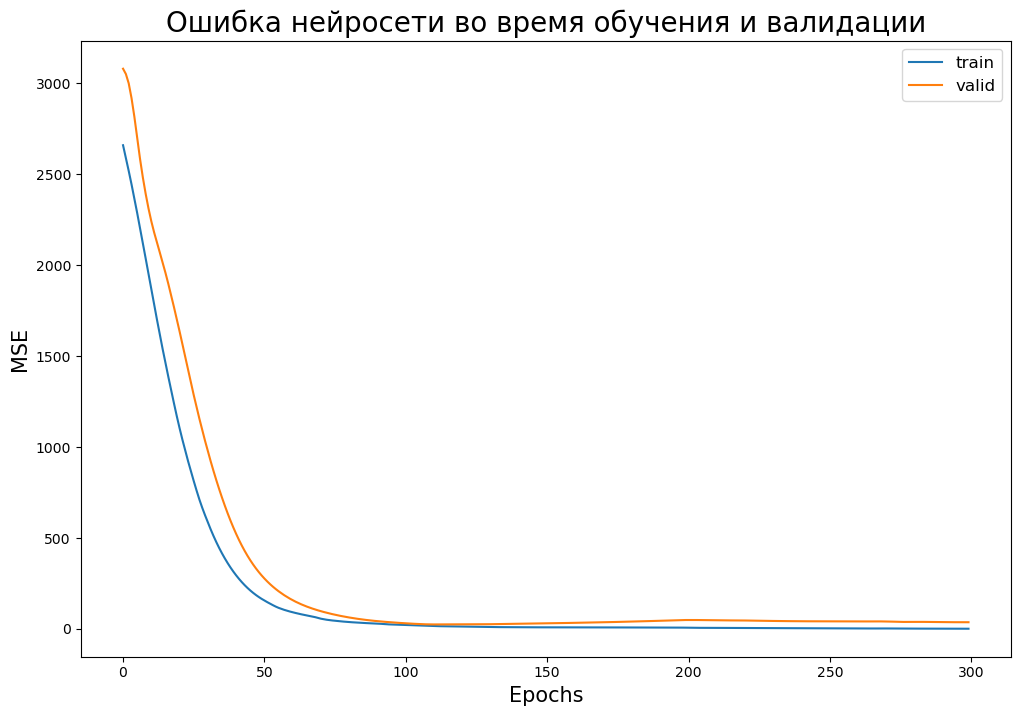

In [39]:
learning_plot(train_loss, valid_loss)

In [40]:
predictions = model_topaz.get_all_predictions(X_scaled, Y.y_topaz)

  Year    Predictions    Absolute Error  Relative Error
------  -------------  ----------------  ----------------
  2010        28.6856         3.71444    11.5 %
  2011        58.9826         1.71741    2.8 %
  2012        59.7506         2.54936    4.1 %
  2013        53.5212         0.821229   1.6 %
  2014        48.5131         0.913054   1.9 %
  2015        38.3444         0.0556282  0.1 %
  2016        54.3227         0.277299   0.5 %
  2017        45.5869         0.113094   0.2 %
  2018        53.8429        10.5571     16.4 %
  2019        51.3378         4.96217    8.8 %


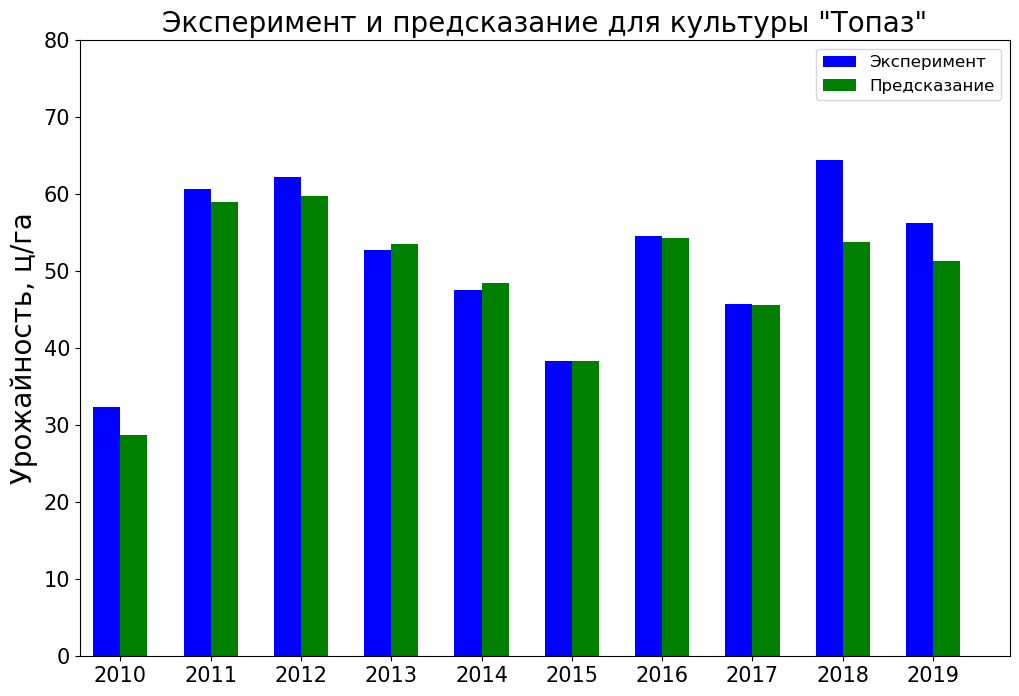

In [41]:
barplot(predictions['Year'], predictions['Predictions'], Y.y_topaz, '"Топаз"')

In [42]:
nn_error = model_topaz.get_all_predictions(X_scaled, Y.y_topaz, False, False)['Relative Error'][-1]
total_info.setdefault('NN_rel_error', []).append(nn_error)
all_preds['topaz'] = predictions['Predictions']
nn_models['topaz'] = model_topaz

### Культура "Михась"

In [43]:
model_mikhas = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                              n_layers=2, 
                              n_neurons=(35, 1), 
                              random_seed=1)

train_loss, valid_loss = model_mikhas.train(X_train_scaled, 
                                            Y_train.y_mikhas, 
                                            X_val_scaled, 
                                            Y_val.y_mikhas,
                                            300,
                                            PATH + 'mikhas.pt')

model_mikhas.load_model(PATH + 'mikhas.pt')

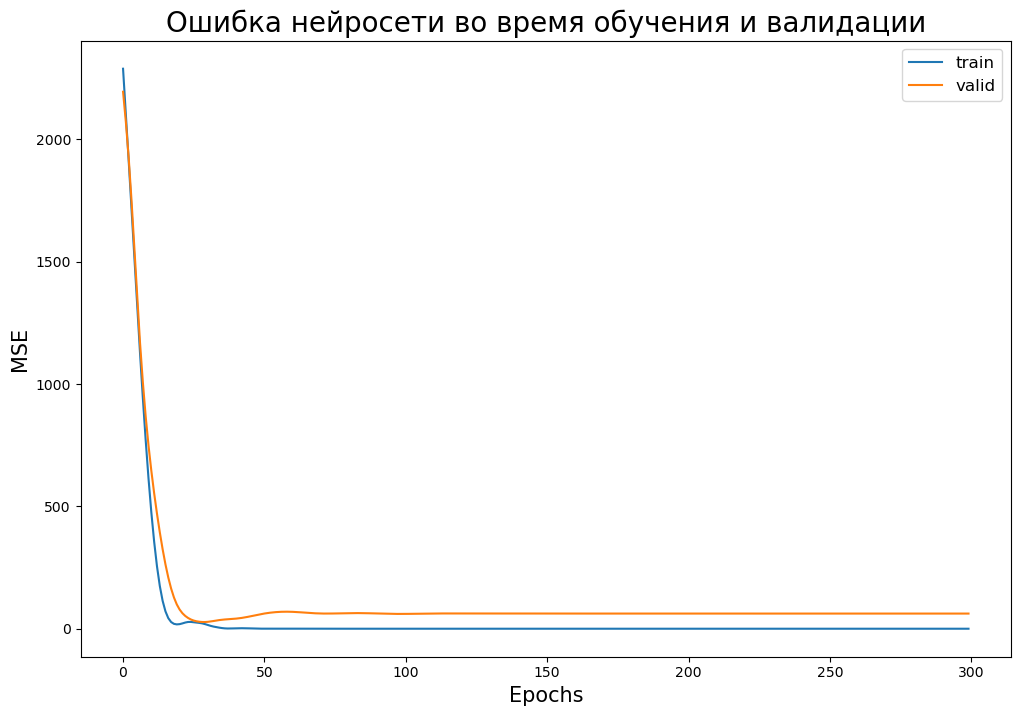

In [44]:
learning_plot(train_loss, valid_loss)

In [45]:
predictions = model_mikhas.get_all_predictions(X_scaled, Y.y_mikhas)

  Year    Predictions    Absolute Error  Relative Error
------  -------------  ----------------  ----------------
  2010        27.5055          0.194478  0.7 %
  2011        66.5056          7.70564   13.1 %
  2012        67.0891          6.68905   11.1 %
  2013        50.3552          1.45524   3.0 %
  2014        47.4465          1.34646   2.9 %
  2015        35.4029          0.302931  0.9 %
  2016        53.8072          1.70716   3.3 %
  2017        40.4014          1.20144   3.1 %
  2018        64.5923          4.89229   8.2 %
  2019        44.1621          5.23788   10.6 %


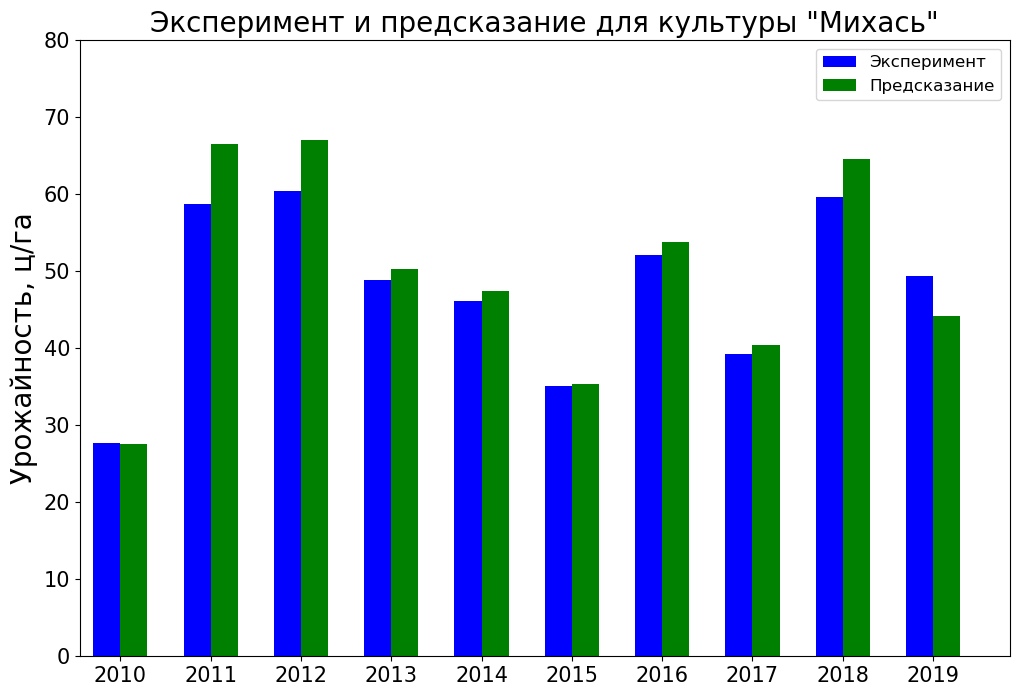

In [46]:
barplot(predictions['Year'], predictions['Predictions'], Y.y_mikhas, '"Михась"')

In [47]:
nn_error = model_mikhas.get_all_predictions(X_scaled, Y.y_mikhas, False, False)['Relative Error'][-1]
total_info.setdefault('NN_rel_error', []).append(nn_error)
all_preds['mikhas'] = predictions['Predictions']
nn_models['mikhas'] = model_mikhas

### Культура "Немчиновский 56"

In [48]:
model_nemch56 = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(25, 1),
                               random_seed=1)

train_loss, valid_loss = model_nemch56.train(X_train_scaled, 
                                             Y_train.y_nemch56, 
                                             X_val_scaled, 
                                             Y_val.y_nemch56, 
                                             300,
                                             PATH + 'nemch56.pt')

model_nemch56.load_model(PATH + 'nemch56.pt')

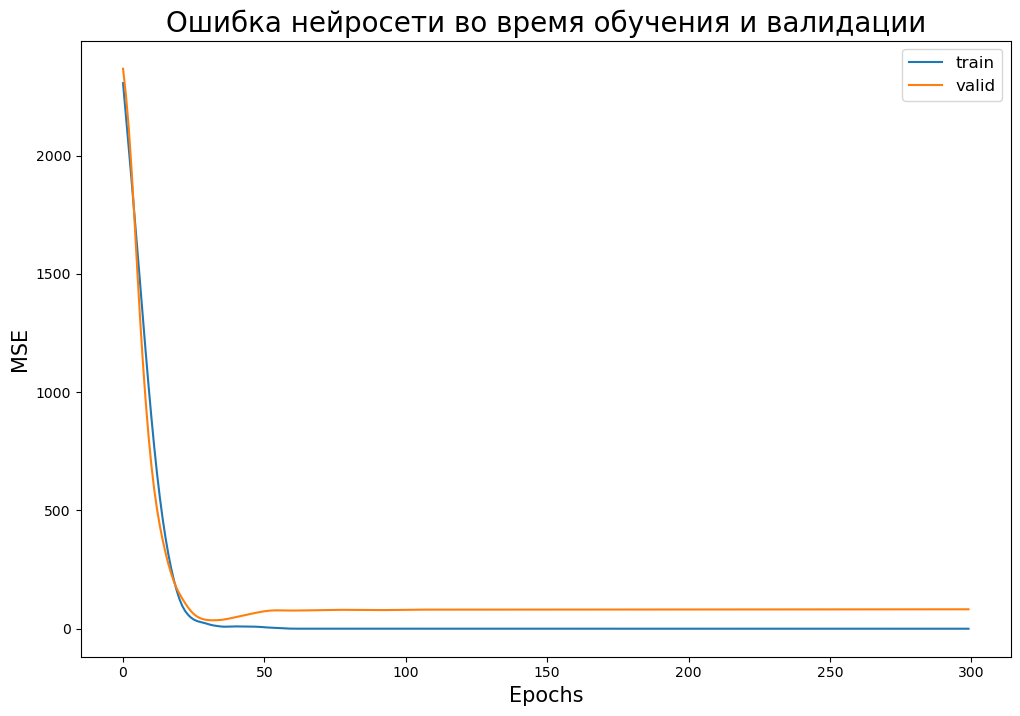

In [49]:
learning_plot(train_loss, valid_loss)

In [50]:
predictions = model_nemch56.get_all_predictions(X_scaled, Y.y_nemch56)

  Year    Predictions    Absolute Error  Relative Error
------  -------------  ----------------  ----------------
  2010        32.5032          2.80319   9.4 %
  2011        58.6428          1.0572    1.8 %
  2012        57.233           0.032975  0.1 %
  2013        52.7037          4.60367   9.6 %
  2014        46.8295          2.52945   5.7 %
  2015        34.0482          0.748191  2.2 %
  2016        58.9045          6.20447   11.8 %
  2017        45.1691          5.06907   12.6 %
  2018        54.7743          2.42572   4.2 %
  2019        43.8367          5.96335   12.0 %


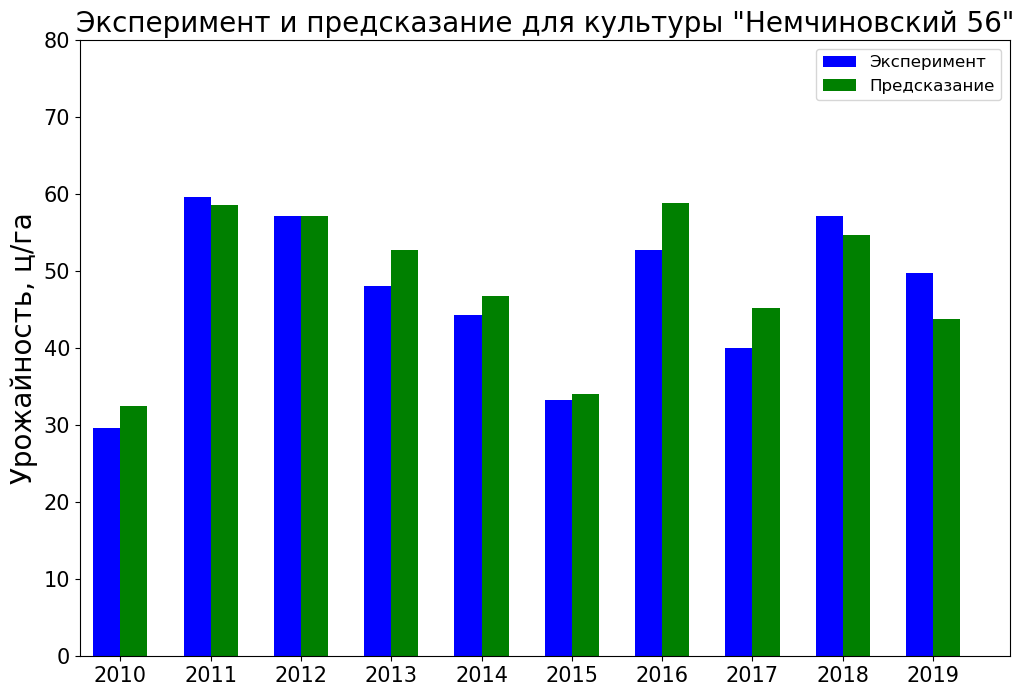

In [51]:
barplot(predictions['Year'], predictions['Predictions'], Y.y_nemch56, '"Немчиновский 56"')

In [52]:
nn_error = model_nemch56.get_all_predictions(X_scaled, Y.y_nemch56, False, False)['Relative Error'][-1]
total_info.setdefault('NN_rel_error', []).append(nn_error)
all_preds['nemch56'] = predictions['Predictions']
nn_models['nemch56'] = model_nemch56

In [53]:
write_list(all_preds, file_name='all_preds')

Done writing list into a binary file


### Разброс ошибок

#### 1. Бутстрэп

In [78]:
# Пробегаем по всем таргетам
for label in varieties:
    errors = []
    
    # Делаем эксперимент 1000 раз
    for i in tqdm(range(1000)):
        
        # Разбиваем на трейн и тест
        data_test = data.sample(1)
        data_train = data.drop(data_test.index) 

        # Обезразмериваем
        X_tr, Y_tr = data_train[feature_names], data_train[target_names]
        X_ts, Y_ts = data_test[feature_names], data_test[target_names]
        sc = StandardScaler()
        X_tr_sc = sc.fit_transform(X_tr)
        X_ts_sc = sc.transform(X_ts)
        
        # Выбираем число нейронов на скрытом слое и обучаем модель
        if label == 'mikhas':
            n = 35
        elif label == 'nemch56':
            n = 25
        else:
            n = 10
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], n_layers=2, n_neurons=(n, 1), random_seed=1)
        model.train(X_tr_sc, Y_tr[f'y_{label}'], X_ts_sc, Y_ts[f'y_{label}'], 300)
        preds, loss = model.predict(X_ts_sc, Y_ts[f'y_{label}'])
        errors.append(TriticaleModel.relative_error(preds, Y_ts[f'y_{label}']))
    write_list(errors, label + '_errors') # Сохраняем ошибки

  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


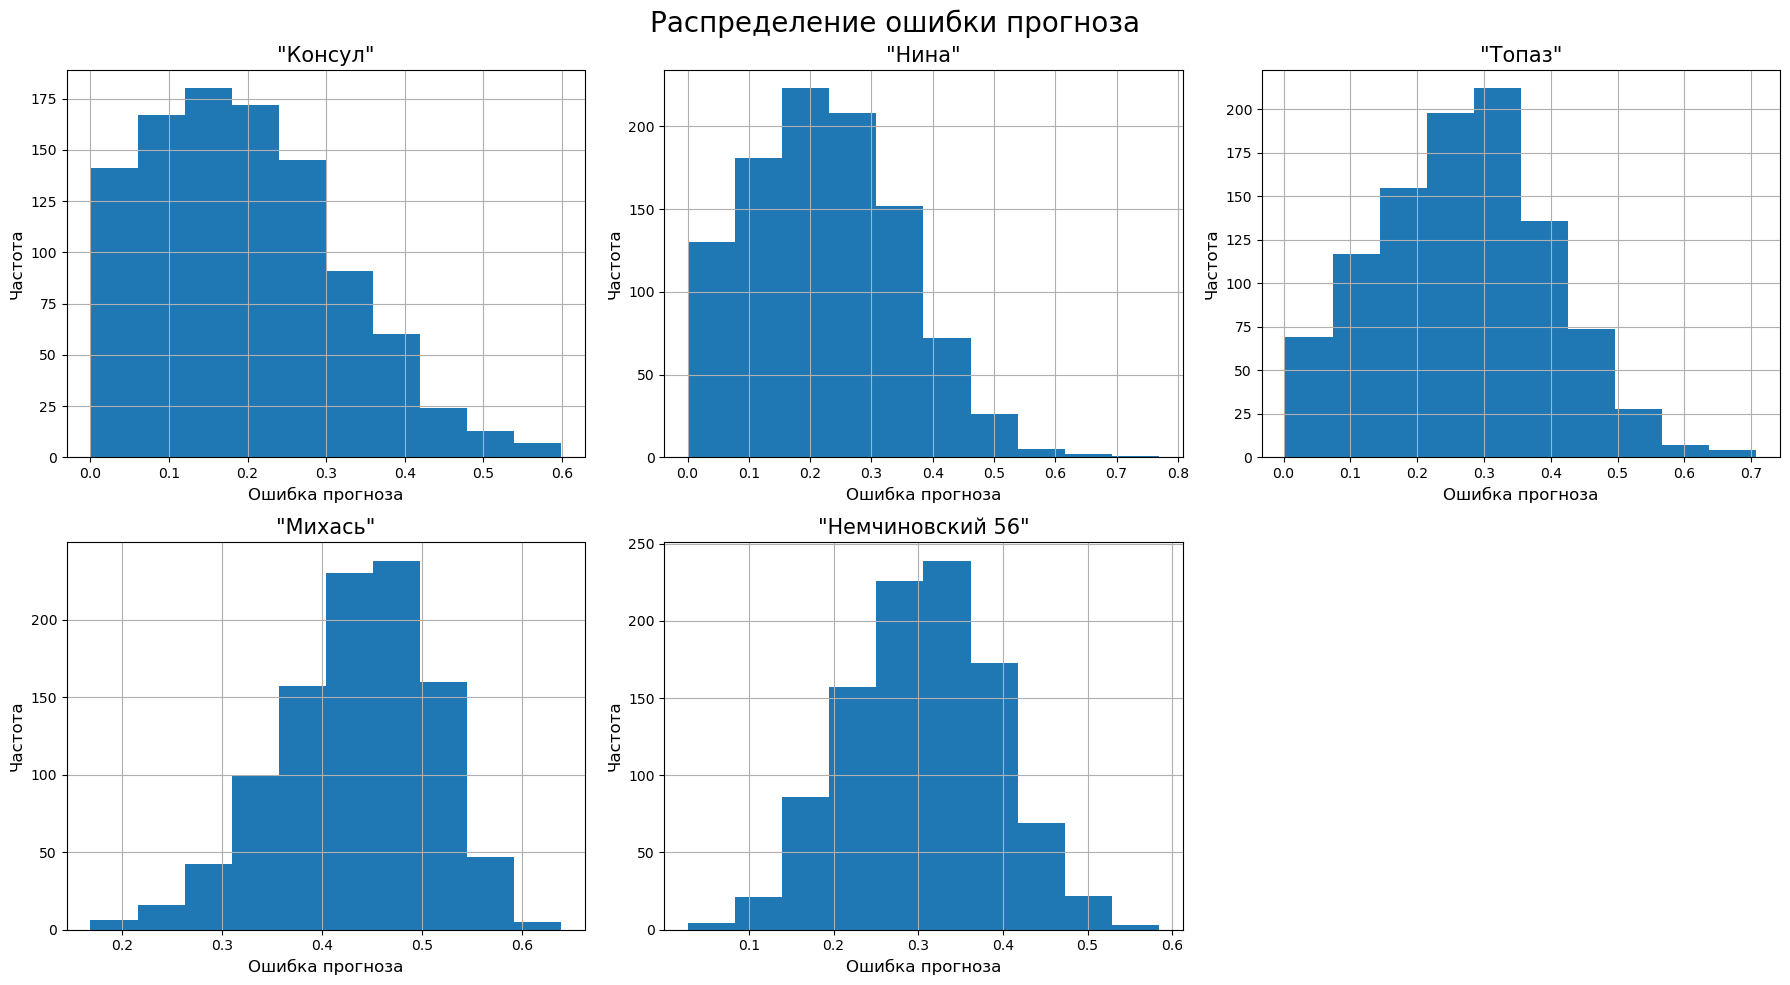

In [80]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Распределение ошибки прогноза", fontsize=20)
fig.delaxes(axes[1][2])
for ax, label in zip(axes.flatten(), varieties):
    errors = read_list(f'er_{label}')
    ax.hist(errors)
    ax.set_title(varieties[label], fontsize=15)
    ax.set_xlabel('Ошибка прогноза', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.92)

In [79]:
for label in varieties:
    errors = read_list(f'{label}_errors')
    freq, val = np.histogram(errors)
    low = np.quantile(errors, 0.025).round(3)
    high = np.quantile(errors, 0.975).round(3)
    print(f"Самый часто встречаемый диапазон ошибок в культуре {varieties[label]}:")
    print((val[np.argmax(freq)].round(3), val[np.argmax(freq) + 1].round(3)))
    print(f"Доля значений: {max(freq/len(errors))}")
    print(f"С вероятностью 0.95 ошибка будет в диапазоне: {(low, high)}")
    print()

Самый часто встречаемый диапазон ошибок в культуре "Консул":
(0.022, 0.089)
Доля значений: 0.219
С вероятностью 0.95 ошибка будет в диапазоне: (0.022, 0.695)

Самый часто встречаемый диапазон ошибок в культуре "Нина":
(0.12, 0.177)
Доля значений: 0.2
С вероятностью 0.95 ошибка будет в диапазоне: (0.004, 0.581)

Самый часто встречаемый диапазон ошибок в культуре "Топаз":
(0.08, 0.142)
Доля значений: 0.222
С вероятностью 0.95 ошибка будет в диапазоне: (0.018, 0.637)

Самый часто встречаемый диапазон ошибок в культуре "Михась":
(0.482, 0.525)
Доля значений: 0.3
С вероятностью 0.95 ошибка будет в диапазоне: (0.09, 0.525)

Самый часто встречаемый диапазон ошибок в культуре "Немчиновский 56":
(0.176, 0.26)
Доля значений: 0.198
С вероятностью 0.95 ошибка будет в диапазоне: (0.008, 0.85)



#### 2. Начальные веса

<div class="text-justify">
Проведем синтетический тест: посмотрим разброс ошибок, получающийхся после предсказания модели, если не фиксировать инициализацию параметров нейросети, а оставить ее случайной.

Для каждой культуры обучим модель 1000 раз и сделаем предсказание на последнем годе. Построим распределения ошибок предсказания.
</div>

In [267]:
# Пробегаем по всем культурам
for label in varieties:
    errors = []
    # Делаем эксперимент 1000 раз
    for i in tqdm(range(1000)):
        if label == 'mikhas':
            n = 35
        elif label == 'nemch56':
            n = 25
        else:
            n = 10
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], n_layers=2, n_neurons=(n, 1))
        model.train(X_train_scaled, Y_train[f'y_{label}'], X_val_scaled, Y_val[f'y_{label}'], 300)
        pred, loss = model.predict(X_scaled[-1], Y[f'y_{label}'][9])
        errors.append(loss ** 0.5 / Y[f'y_{label}'][9])
    write_list(errors, f'er_{label}') # Сохраняем ошибки

  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


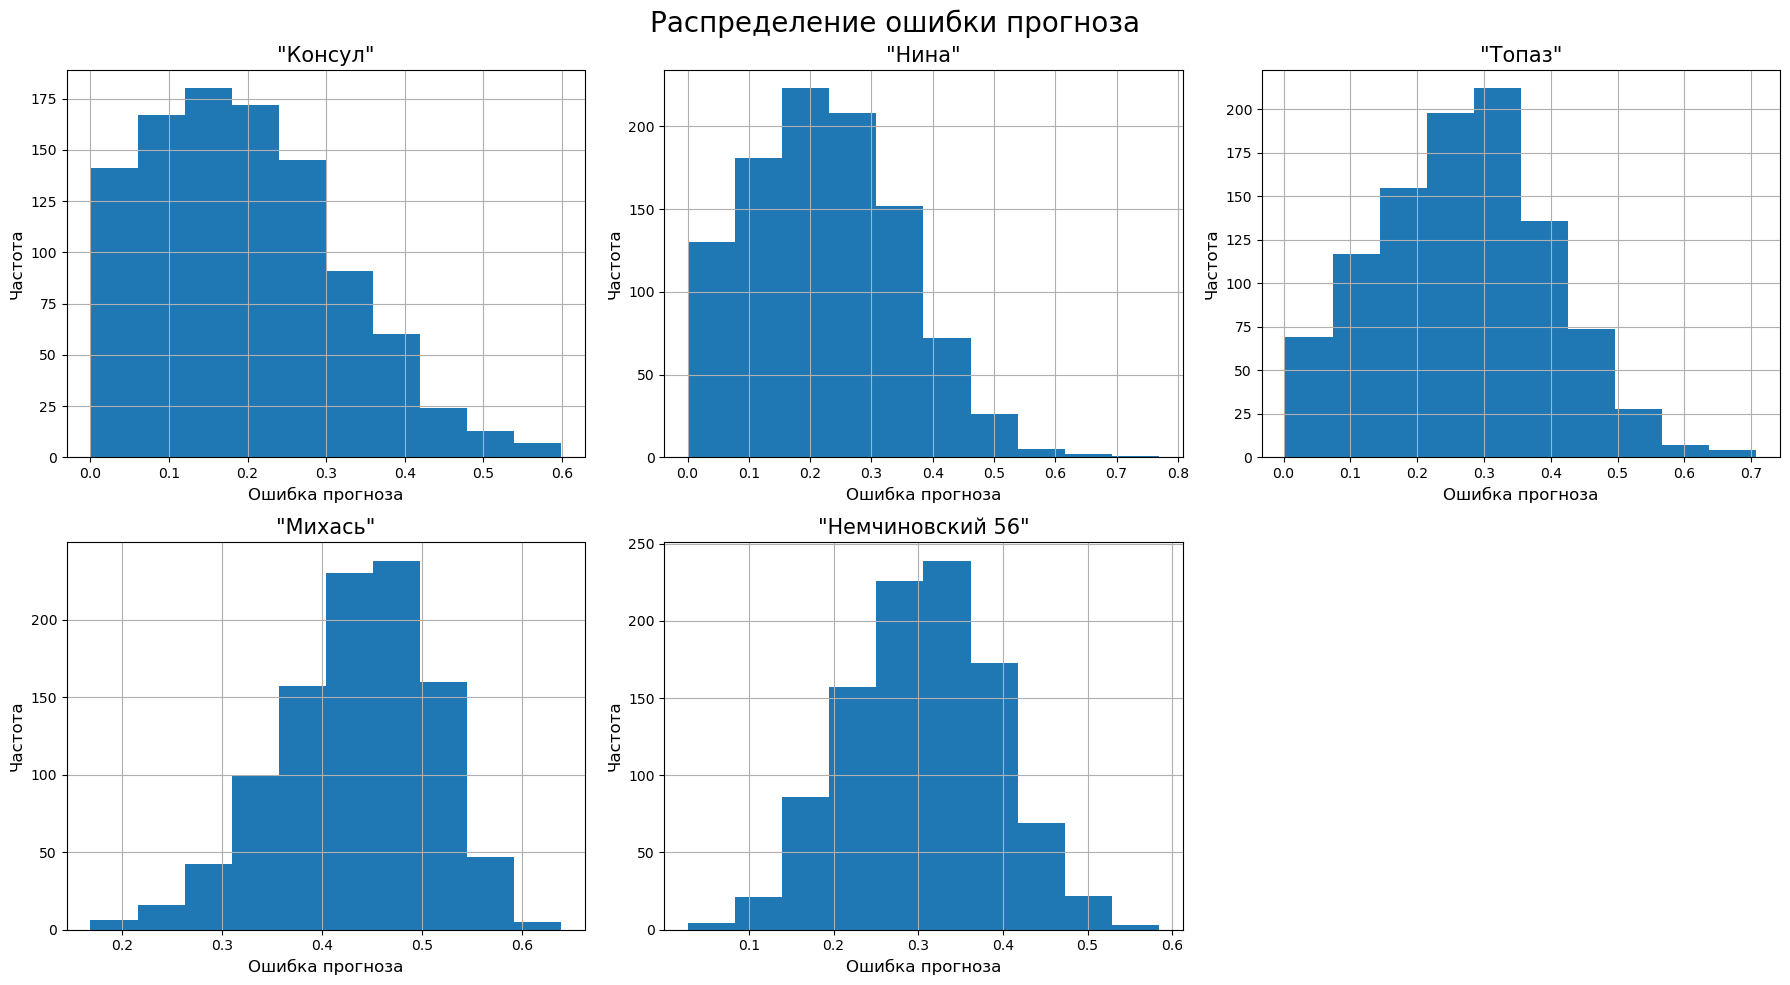

In [268]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Распределение ошибки прогноза", fontsize=20)
fig.delaxes(axes[1][2])
for ax, label in zip(axes.flatten(), varieties):
    errors = read_list(f'er_{label}')
    ax.hist(errors)
    ax.set_title(varieties[label], fontsize=15)
    ax.set_xlabel('Ошибка прогноза', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.92)

In [269]:
for label in varieties:
    errors = read_list(f'er_{label}')
    freq, val = np.histogram(errors)
    low = np.quantile(errors, 0.025).round(3)
    high = np.quantile(errors, 0.975).round(3)
    print(f"Самый часто встречаемый диапазон ошибок в культуре {varieties[label]}:")
    print((val[np.argmax(freq)].round(3), val[np.argmax(freq) + 1].round(3)))
    print(f"Доля значений: {max(freq/len(errors))}")
    print(f"С вероятностью 0.95 ошибка будет в диапазоне: {(low, high)}")
    print()

Самый часто встречаемый диапазон ошибок в культуре "Консул":
(0.12, 0.18)
Доля значений: 0.18
С вероятностью 0.95 ошибка будет в диапазоне: (0.009, 0.459)

Самый часто встречаемый диапазон ошибок в культуре "Нина":
(0.154, 0.231)
Доля значений: 0.223
С вероятностью 0.95 ошибка будет в диапазоне: (0.019, 0.481)

Самый часто встречаемый диапазон ошибок в культуре "Топаз":
(0.285, 0.355)
Доля значений: 0.212
С вероятностью 0.95 ошибка будет в диапазоне: (0.022, 0.517)

Самый часто встречаемый диапазон ошибок в культуре "Михась":
(0.451, 0.498)
Доля значений: 0.238
С вероятностью 0.95 ошибка будет в диапазоне: (0.277, 0.569)

Самый часто встречаемый диапазон ошибок в культуре "Немчиновский 56":
(0.306, 0.362)
Доля значений: 0.239
С вероятностью 0.95 ошибка будет в диапазоне: (0.139, 0.472)



Таким образом, можно видеть достаточно низкую точность предсказания, распределение ошибок оказывается достаточно широким. 

### Тестирование на экстремальных данных

Посмотрим на статистику данных, выберем максимальные/минимальные значения

In [270]:
data.describe()

,T_posev-vskhod,H_posev-vskhod,T_vskhod-kuschenie,H_vskhod-kuschenie,T_kuschenie-trubka,H_kuschenie-trubka,T_trubka-koloshenie,H_trubka-koloshenie,T_koloshenie-sozrevanie,H_koloshenie-sozrevanie,...,Gumus,P,K,vlazhnost,T_pochvy_posev,y_konsul,y_nina,y_topaz,y_mikhas,y_nemch56
count,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000
mean,12.275143,15.15000,9.284667,19.100000,8.894638,15.489000,15.452190,26.244167,17.485846,27.492143,...,1.977000,141.000000,134.900000,21.700000,6.300000,52.520000,49.41000,51.510000,47.740000,47.210000
std,1.684972,7.63417,2.341999,12.377848,1.637242,5.423511,1.817350,11.220367,0.945933,10.945612,...,0.121568,16.964014,5.586691,3.802046,1.251666,11.170278,10.40635,10.472445,10.983543,10.286717
min,8.257143,3.50000,5.933333,8.333333,5.011364,7.166667,13.351613,12.525000,16.091667,13.800000,...,1.800000,110.000000,125.000000,18.000000,5.000000,33.200000,30.30000,32.400000,27.700000,29.700000
25%,12.203571,10.00000,7.740000,9.833333,8.518566,11.463333,13.988710,15.500000,16.768021,19.400000,...,1.885000,128.500000,133.250000,19.250000,5.000000,47.375000,44.32500,46.175000,40.925000,41.150000
50%,12.355238,13.75000,9.673333,13.500000,9.047724,15.300000,14.753528,26.375000,17.562024,30.619048,...,1.990000,147.500000,135.000000,20.500000,6.500000,54.300000,51.40000,53.650000,49.150000,48.950000
75%,12.428571,22.00000,10.605000,26.041667,10.006326,20.429167,17.272446,37.437500,17.979134,31.250000,...,2.007500,154.250000,137.500000,22.750000,7.000000,61.575000,58.15000,59.600000,57.125000,56.075000
max,15.028571,26.00000,13.546667,45.500000,10.668889,22.600000,18.041935,39.666667,18.861905,49.550000,...,2.210000,158.000000,144.000000,30.000000,8.000000,65.800000,60.80000,64.400000,60.400000,59.700000


In [272]:
# Найдем минимальные температуру и количество осадков, которые попадалась в наблюдениях
t_min = get_extreme_value(data, 'T_', 100, 'min')
h_min = get_extreme_value(data, 'H_', 10000, 'min')

In [273]:
# Добавим новые строки
data_new = add_value_to_new_row(data, 'T', t_min)  # с минимальной наблюдаемой средней температурой за 10 лет
data_new = add_value_to_new_row(data_new, 'H_', h_min) # с минимальным наблюдаемым кол количеством осадков за 10 лет
data_new = add_value_to_new_row(data_new, 'T', -5) # температура всегда была -5

In [274]:
data_new.tail(3)

,T_posev-vskhod,H_posev-vskhod,T_vskhod-kuschenie,H_vskhod-kuschenie,T_kuschenie-trubka,H_kuschenie-trubka,T_trubka-koloshenie,H_trubka-koloshenie,T_koloshenie-sozrevanie,H_koloshenie-sozrevanie,...,Gumus,P,K,vlazhnost,T_pochvy_posev,y_konsul,y_nina,y_topaz,y_mikhas,y_nemch56
10,5.000000,26.0,5.000000,10.333333,5.000000,11.340000,5.000000,39.666667,5.000000,30.666667,...,2.0,155.0,141.0,26.0,5.0,37.3,36.4,38.4,35.1,33.3
11,11.926667,3.5,9.753333,3.500000,8.417778,3.500000,16.483333,3.500000,18.861905,3.500000,...,1.8,120.0,135.0,21.0,5.0,33.2,30.3,32.4,27.7,29.7
12,-5.000000,22.0,-5.000000,9.666667,-5.000000,7.166667,-5.000000,37.500000,-5.000000,13.800000,...,2.0,156.0,136.0,18.0,-5.0,65.8,60.7,62.3,60.4,57.2


In [275]:
X_new, Y_new = data_new.iloc[len(data_new)-3:, :16], data_new.iloc[len(data_new)-3:, 16:]
#X_new_train_scaled, Y_new_train, X_new_val_scaled, Y_new_val = preprocessing(X_new, Y_new, 9)

In [276]:
# Не забываем использовать старый скейлер
X_new_scaled = scaler.transform(X_new)

Посмотрим как ведет себя линейная модель, например, для "Консула":

In [277]:
linreg_true = Y_new.reset_index(drop=True).y_konsul.values
linreg_preds = np.array([linreg_hist['models'][0]  \
                         .predict(X_new_scaled[n]  \
                         .reshape(1, 16))[0]       \
                         .round(1) for n in range(3)])

print('Эксперимент:', end=' ')
print(*linreg_true, sep=', ')
print('Предсказание:', end=' ')
print(*linreg_preds, sep=', ')
print("Отклонение от типичных значениий:", end=' ')
print(np.mean(np.abs(linreg_preds - linreg_true) / linreg_true))

Эксперимент: 37.3, 33.2, 65.8
Предсказание: 91.3, 49.9, 142.5
Отклонение от типичных значениий: 1.0387955744193886


Выбросы предсказуемо плохо повлияли на результат линейной модели, что можно видеть из сильно отклонившихся результатов предсказаний от типичных экспериментальных, т.е. модель работает некорректно, что логично, поскольку она не видела в процессе обучения таких условий. Но надо иметь в виду, что реальные значения урожайности в сгенерированных векторах были бы около 0.

In [278]:
Y_new

,y_konsul,y_nina,y_topaz,y_mikhas,y_nemch56
10,37.3,36.4,38.4,35.1,33.3
11,33.2,30.3,32.4,27.7,29.7
12,65.8,60.7,62.3,60.4,57.2


Посмотрим для нейронных сетей

In [279]:
Y_new = Y_new.reset_index(drop=True)
t = '%-28s%-s    %-s    %-s'
for n in range(3):
    row = X_new_scaled[n].reshape(1, 16)
    print(f'Номер нового объекта: {n + 1}     Pred    True    Error')
    print()
    for name in varieties:
        pred, true = round(nn_models[name].predict(row)[0], 1), Y_new[f'y_{name}'][n]
        error = round(abs(pred - true) / true, 3)
        print(t % (f'{varieties[name]}:', true, pred, error))
    print()

Номер нового объекта: 1     Pred    True    Error

"Консул":                   37.3    49.2    0.319
"Нина":                     36.4    53.4    0.467
"Топаз":                    38.4    52.7    0.372
"Михась":                   35.1    61.6    0.755
"Немчиновский 56":          33.3    59.2    0.778

Номер нового объекта: 2     Pred    True    Error

"Консул":                   33.2    26.2    0.211
"Нина":                     30.3    22.5    0.257
"Топаз":                    32.4    17.6    0.457
"Михась":                   27.7    36.1    0.303
"Немчиновский 56":          29.7    31.9    0.074

Номер нового объекта: 3     Pred    True    Error

"Консул":                   65.8    54.6    0.17
"Нина":                     60.7    58.0    0.044
"Топаз":                    62.3    58.9    0.055
"Михась":                   60.4    62.3    0.031
"Немчиновский 56":          57.2    57.5    0.005



В случае нейронной сети тоже можно заметить похожую особенность, но не так резко выражено: чем более плохие условия (третий урожай рос всегда при температуре -5), тем выше ошибка по сравнению с типичными значениями. Снова стоит отметить, что в реальности на подобных сгенерированных объектах урожайность была бы близка к нулю.

## Заключение
---

Выведем таблицу с тремя моделями, их предсказаниями и относительными ошибками. Сравним результаты между собой.

In [280]:
# Обернем словарь в DataFrame для лучшей визуализации
df_total = pd.DataFrame(total_info, index=varieties.values())
# Посчитаем ошибки для бейзлайна и линейной регрессии
df_total['BL_rel_error'] = TriticaleModel.relative_error(df_total.Baseline, df_total.Y_true)
df_total['LR_rel_error'] = TriticaleModel.relative_error(df_total.Linreg, df_total.Y_true)

In [281]:
df_total

,Y_true,Baseline,Linreg,NN_rel_error,BL_rel_error,LR_rel_error
"""Консул""",54.8,52.266667,46.888160,0.000,0.046229,0.144377
"""Нина""",52.3,49.088889,43.864929,0.004,0.061398,0.161282
"""Топаз""",56.3,50.977778,42.971096,0.088,0.094533,0.236748
"""Михась""",49.4,47.555556,40.528763,0.106,0.037337,0.179580
"""Немчиновский 56""",49.8,46.922222,42.448284,0.120,0.057787,0.147625


In [282]:
df_total.iloc[:, 3:].style.highlight_min(color="red", axis=1)

,NN_rel_error,BL_rel_error,LR_rel_error
"""Консул""",0.000000,0.046229,0.144377
"""Нина""",0.004000,0.061398,0.161282
"""Топаз""",0.088000,0.094533,0.236748
"""Михась""",0.106000,0.037337,0.179580
"""Немчиновский 56""",0.120000,0.057787,0.147625


<div class="text-justify">
Можем видеть, что из трех предложенных способов оценки количества урожая нейронная сеть показала для большинства культур наилучший результат. Вообще использование нейронной сети не всегда является лучшим способом предсказания. Существует проблема, связанная с малым количеством данных: приходится работать по 10 точкам (10 лет). Поэтому сложно утверждать, что во всех случаях такой подход будет наилучшим. Кроме того, была показана достаточно низкая точность предсказания, сделав выборку моделей со случайной инциализацией параметров. Возможно, подобрав начальные значения весов, можно добиться более высокой точности.
</div>